![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab

# Example: Pedestrian Detection using HOG features

In this exercise pedestrian detection will be performed using HoG and a simple KNN classifier.


**WARNING:** This exercise is for pedagogical purposes only, with the idea that the solution to this problem can be executed in a couple of minutes. A good people detector follows this idea but with thousands of images per class.

#Libraries

In [ ]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 261 (delta 152), reused 177 (delta 74), pack-reused 0
Receiving objects: 100% (261/261), 68.46 KiB | 5.27 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43704 sha256=6ba6b6c34364d007faff1a06ddf27b6ff624156a66e9bf4df17113392b2a880b
  Stored in directory: /tmp/pip-ephem-wheel-cache-b6fspnh7/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [ ]:
import numpy             as np
import matplotlib.pyplot as plt
from   sklearn.metrics   import confusion_matrix, accuracy_score
from   sklearn.neighbors import KNeighborsClassifier
from   tqdm.auto         import tqdm
from   seaborn           import heatmap
from   balu3.io.misc     import imageload
from   balu3.ft.norm     import minmax
from   balu3.fx.chr      import hog
from   balu3.cl.basics   import SplitTrainTest,ClassifierKNN

# Example 1: Pedestrian vs. non-pedestrian recognition

* Class 0: People (pedestrians)

* Class 1: Non-People (photos of the parts of the city with no people)

The database contains 680 images per class of 160x96 pixels in grayscale.

## Database loading

The database consists of 2 classes and 120 images per class. They are stored in the facedetection folder with the format face_xx_nnn.png, where xx is the ID of the class (01 for faces, 02 for non-faces) and nnn is the number of the class photo (01, 02, ... 120). The photos are 160x96 pixels.

In [ ]:
!wget https://www.dropbox.com/s/np5pn5bve14oypa/persons.zip
!unzip -qq persons.zip

--2023-07-18 14:49:08--  https://www.dropbox.com/s/np5pn5bve14oypa/persons.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/np5pn5bve14oypa/persons.zip [following]
--2023-07-18 14:49:08--  https://www.dropbox.com/s/raw/np5pn5bve14oypa/persons.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdf94c8e8f24dd38dbfbbb2b3ee.dl.dropboxusercontent.com/cd/0/inline/CAHIoWz_jD0JV66refn3g2SBB91ZXwrEUyEzmOR4OTP_OawvhNcUzTXDGC48aoAP0D1tnyU87sshU2og_JDJ5nXYoBb-ng66lfGDD6uPqHB1NXyHTPp_GTalenwi4rWIFMcnASlSMIsP5VPkXDSxZbeMTZQMWlhYKMdE-ytWeD_wXw/file# [following]
--2023-07-18 14:49:09--  https://ucdf94c8e8f24dd38dbfbbb2b3ee.dl.dropboxusercontent.com/cd/0/inline/CAHIoWz_jD0JV66refn3g2SBB91ZXwrEUyEzmOR4OTP_OawvhNcUzTXDGC48aoAP0D1tnyU87sshU2og_JD

Class Pedestrian:


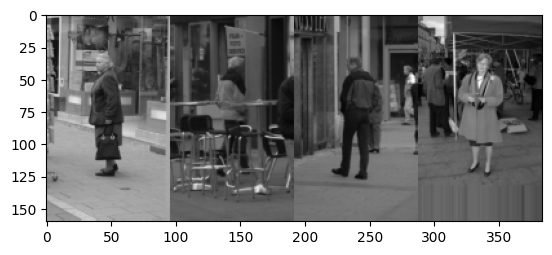


Class Non-Pedestrian:


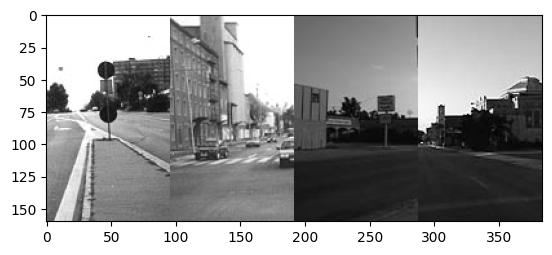

In [ ]:
print('Class Pedestrian:')
I1    = 255*imageload('persons/person_',1,2,10,4)
I2    = 255*imageload('persons/person_',1,2,15,4)
I3    = 255*imageload('persons/person_',1,2,25,4)
I4    = 255*imageload('persons/person_',1,2,35,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()

print('')
print('Class Non-Pedestrian:')
I1    = 255*imageload('persons/person_',2,2,10,4)
I2    = 255*imageload('persons/person_',2,2,15,4)
I3    = 255*imageload('persons/person_',2,2,25,4)
I4    = 255*imageload('persons/person_',2,2,35,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()


## HOG feature extraction

Syntaxis:

`f  = hog_features(image, v_windows=v, h_windows=h, n_bins=b)`

the image is divided into `v` x `h` cells, and a HoG descriptor of `b` bins is extracted from each cell. The descriptor f has `v*h*b` elements.


In [ ]:
K    = 2     # Number of classes
N    = 680   # Number of images per class
Mhog = 1620  # Number of elements of HoG vector

Xhog  = np.zeros((K*N,Mhog))    # K*N samples (rows), y Mlbp features (columns)

y     = np.zeros((K*N),'int')   # ground truth

bn    = 9
px    = 16
cl    = 2

t = 0
print('Loading images and extracting features...')
for j in range(K):            # for each class
  print('Extracting features: batch '+str(j+1)+'/'+str(K))
  for i in tqdm(range(N)):                # for each image of the class
    # Image
    img    = 255*imageload('persons/person_',j+1,2,i+1,4)

    # HoG
    Xhog[t,:] = hog(img, orientations=bn, pixels_per_cell=(px,px),cells_per_block=(cl,cl))
    y[t] = j # sample t belongs to class j
    t = t+1

Loading images and extracting features...
Extracting features: batch 1/2


  0%|          | 0/680 [00:00<?, ?it/s]

Extracting features: batch 2/2


  0%|          | 0/680 [00:00<?, ?it/s]

## Classification using HoG

600 images per class for training and 80 images per class for testing.

Entrenando con 1200 muestras y probando con 160 muestras (de 1620 características)...
Testing Accuracy = 93.75%
Matriz de Confusión:
[[77  3]
 [ 7 73]]


<Axes: >

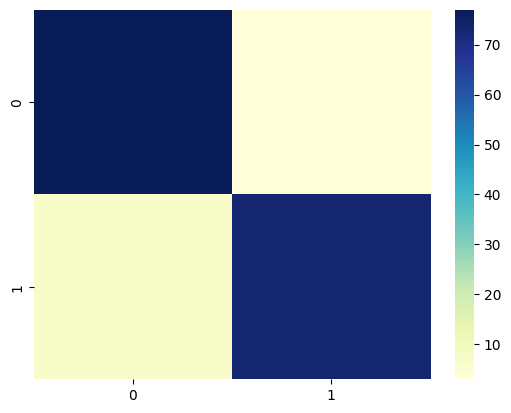

In [ ]:
# Step 1: define of X
X = Xhog

# Step 2: split training/testing
ntrain = 600
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,ntrain)

# Step 3: classification and evaluation of accuracy
acc,C = ClassifierKNN(Xtrain,ytrain,Xtest,ytest)

heatmap(C, cmap="YlGnBu")

# Example 2: pedestrian - non-pedestrian - pedestrian with bicycle


* Class 0: People (pedestrian)

* Class 1: Non-People (photos of the parts of the city without people)

* Class 2: Pedestrians with bicycle


The database contains 254 images per class of 160x96 pixels in grayscale.

## Dataset

In [ ]:
!wget https://www.dropbox.com/s/ckm36dwdj7g13qe/bikes.zip
!unzip -qq bikes.zip

--2023-07-18 14:49:26--  https://www.dropbox.com/s/ckm36dwdj7g13qe/bikes.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ckm36dwdj7g13qe/bikes.zip [following]
--2023-07-18 14:49:26--  https://www.dropbox.com/s/raw/ckm36dwdj7g13qe/bikes.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc48bb97bfeb4e1e97a9479fccb5.dl.dropboxusercontent.com/cd/0/inline/CAEvTruraN5aJgoApfu-pHGlirWCTG-UV9w7amKbOYUXNnuezO4yTzItW6qNQ6bfm_EyhEA4eR8rlcMiGOfJwfyc3EVqk090eyIqP11Y5pAf5YfrzaJCYfLtQCQC2AsQzwNsGrqwk8p4GOWRGXgMhLOr3mHek4-G_3gomLFC-TNhIQ/file# [following]
--2023-07-18 14:49:27--  https://uc48bb97bfeb4e1e97a9479fccb5.dl.dropboxusercontent.com/cd/0/inline/CAEvTruraN5aJgoApfu-pHGlirWCTG-UV9w7amKbOYUXNnuezO4yTzItW6qNQ6bfm_EyhEA4eR8rlcMiGOfJwfyc3

Class Pedestrian:


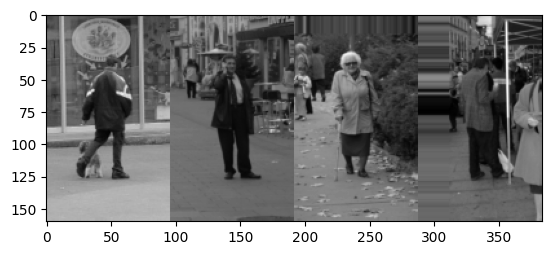


Clase Non-Pedestrian:


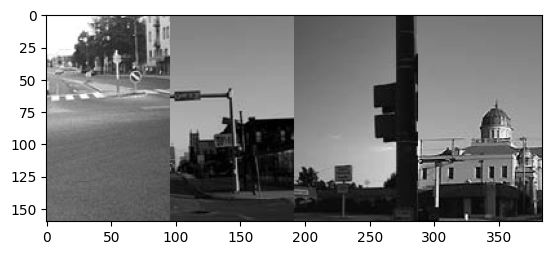


Clase Pedestrian-with-Bike:


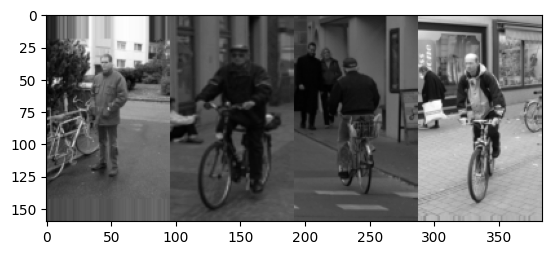

In [ ]:
print('Class Pedestrian:')
I1    = 255*imageload('bikes/person_',1,2, 7,4)
I2    = 255*imageload('bikes/person_',1,2,17,4)
I3    = 255*imageload('bikes/person_',1,2,27,4)
I4    = 255*imageload('bikes/person_',1,2,37,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()

print('')
print('Clase Non-Pedestrian:')
I1    = 255*imageload('bikes/person_',2,2, 7,4)
I2    = 255*imageload('bikes/person_',2,2,17,4)
I3    = 255*imageload('bikes/person_',2,2,27,4)
I4    = 255*imageload('bikes/person_',2,2,37,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()

print('')
print('Clase Pedestrian-with-Bike:')
I1    = 255*imageload('bikes/person_',3,2, 7,4)
I2    = 255*imageload('bikes/person_',3,2,17,4)
I3    = 255*imageload('bikes/person_',3,2,27,4)
I4    = 255*imageload('bikes/person_',3,2,37,4)
I = np.concatenate((I1,I2,I3,I4),axis=1)
plt.imshow(I,cmap='gray')
plt.show()


## Extracción de características HoG

In [ ]:
K    = 3
N    = 254
Xhog = np.zeros((K*N,Mhog))
y    = np.zeros((K*N),'int')
t    = 0
for j in range(K):
  for i in tqdm(range(N)):
    img       = 255*imageload('bikes/person_',j+1,2,i+1,4)
    Xhog[t,:] = hog(img, orientations=bn, pixels_per_cell=(px,px),cells_per_block=(cl,cl))
    y[t]      = j
    t         = t+1

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

## Classification using HoG

230 images per class for training and 24 images per class for testing.

Entrenando con 690 muestras y probando con 72 muestras (de 1620 características)...
Testing Accuracy = 80.55555555555556%
Matriz de Confusión:
[[19  5  0]
 [ 1 18  5]
 [ 3  0 21]]


<Axes: >

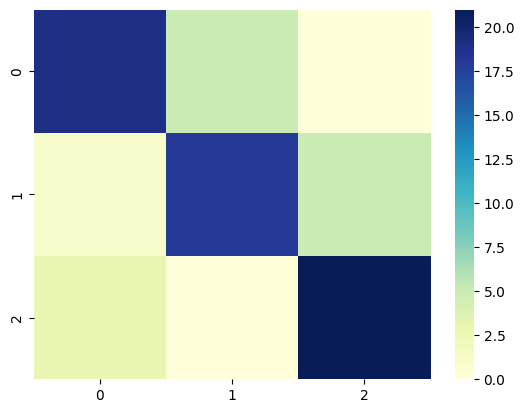

In [ ]:
X      = Xhog
ntrain = 230
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,ntrain)
acc,C  = ClassifierKNN(Xtrain,ytrain,Xtest,ytest)
heatmap(C, cmap="YlGnBu")